### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [4]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [5]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [6]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [7]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [8]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [9]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 81, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [10]:
# er_500_accuracy_array_without_drift = read_results(
#     "./logs/01-20-25-05-14-13-seq-cifar100-er-buf-500-drift-6-n-2-adaptation-0.json"
# )
# # 9.43, 9.72, 9.75, 9.82, 9.97
# # 9.738 ± 0.17656726763474623
# # plot_results(
# #     er_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_500_accuracy_array_without_drift)[1]

In [11]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-05-14-13-seq-cifar100-er-buf-500-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-05-14-13-seq-cifar100-er-buf-500-drift-6-n-2-adaptation-0.json
FAA: 9.75 ± 0.00
Avg. Forgetting: 74.80 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [12]:
# er_500_accuracy_array_with_drift = read_results(
#     "./logs/01-20-25-07-10-14-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 9.36, 9.33, 9.49, 9.52, 9.55
# # 9.45 ± 0.08831760866327869
# # plot_results(
# #     er_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 4, 7",
# # )
# average_forgetting(er_500_accuracy_array_with_drift)[1]

In [13]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-07-10-14-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-07-10-14-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-0.json
FAA: 9.49 ± 0.00
Avg. Forgetting: 74.94 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [14]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-20-25-21-28-50-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 13.86, 14.48, 14.51
# # 14.283333333333333 ± 0.2995923155816179

In [15]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-19-12-15-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 11.86, 12.29, 12.29
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
# )

In [16]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-18-33-01-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-19-54-22-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-12-15-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 12.15 ± 0.20
Avg. Forgetting: 69.16 ± 0.29


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [17]:
# before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-01-07-57-seq-cifar100-er-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 12.49, 12.52, 12.71
# # 12.573333333333332 ± 0.09741092797468347

In [18]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-23-25-20-55-19-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 12.12, 12.65, 12.93
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
# )

In [19]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-20-25-07-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-21-25-20-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-20-55-19-seq-cifar100-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 12.57 ± 0.34
Avg. Forgetting: 70.55 ± 0.33


### Cumulative Plots

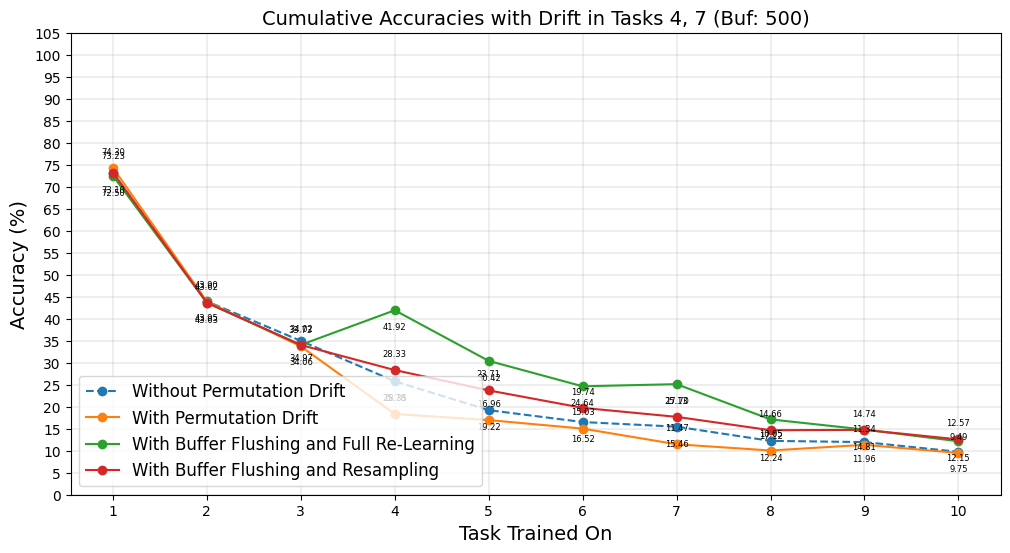

In [20]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [21]:
# er_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-13-25-15-13-00-seq-cifar100-er-buf-5000-drift-6-n-2-severity-5-adaptation-0-cpd-0.json"
# )
# # 22.63, 22.76, 22.9, 22.97, 23.21
# # 22.894 ± 0.1966316352980875
# # plot_results(
# #     er_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_5000_accuracy_array_without_drift)[1]

In [22]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-13-25-15-13-00-seq-cifar100-er-buf-5000-drift-6-n-2-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-13-25-15-13-00-seq-cifar100-er-buf-5000-drift-6-n-2-severity-5-adaptation-0-cpd-0.json
FAA: 22.90 ± 0.00
Avg. Forgetting: 57.28 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [23]:
# er_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-13-25-17-12-45-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-0-cpd-0.json"
# )
# # 15.35, 15.47, 15.56, 15.94, 16.54
# # 15.772 ± 0.43180551177584525
# # plot_results(
# #     er_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 4, 7",
# # )
# average_forgetting(er_5000_accuracy_array_with_drift)[1]

In [24]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-13-25-17-12-45-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-0-cpd-0.json"
)

1 files found
1: ./logs/01-13-25-17-12-45-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-0-cpd-0.json
FAA: 15.56 ± 0.00
Avg. Forgetting: 64.33 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [25]:
# before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-14-25-00-28-42-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-1-cpd-0.json"
# )
# # 25.99, 26.03, 26.09, 26.13, 26.51
# # 26.15 ± 0.18633303518163463

In [26]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-20-18-17-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 23.70, 24.15, 24.26
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
# )

In [27]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-18-43-35-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-19-31-38-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-20-18-17-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 24.04 ± 0.24
Avg. Forgetting: 53.18 ± 0.26


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [28]:
# before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-14-25-01-32-25-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-2-cpd-0.json"
# )
# # 25.62, 25.80, 26.05, 26.42, 26.45
# # 26.068 ± 0.32944802321458827

In [29]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-23-25-20-49-20-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 25.31, 25.69, 26.12
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
# )

In [30]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-20-49-20-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-21-21-12-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-21-53-57-seq-cifar100-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 25.71 ± 0.33
Avg. Forgetting: 53.43 ± 0.27


### Cumulative Plots

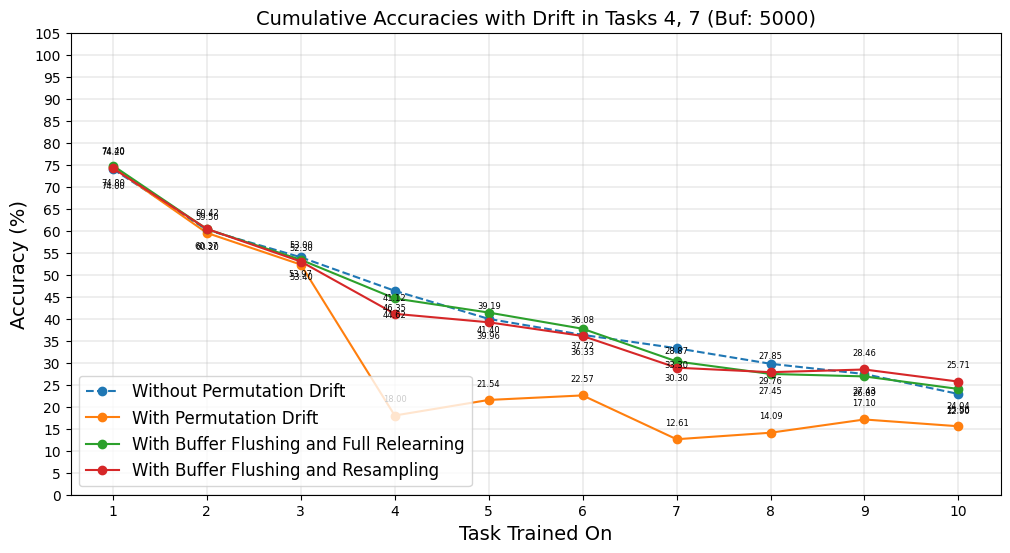

In [31]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [32]:
# er_ace_500_accuracy_array_without_drift = read_results(
#     "./logs/01-20-25-05-56-24-seq-cifar100-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
# )
# # 21.55, 21.91, 22.40
# # 21.953333333333333 ± 0.3483612429010365
# # plot_results(
# #     er_ace_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

In [33]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-05-56-24-seq-cifar100-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-05-56-24-seq-cifar100-er_ace-buf-500-drift-6-n-2-adaptation-0.json
FAA: 21.91 ± 0.00
Avg. Forgetting: 39.40 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [34]:
# er_ace_500_accuracy_array_with_drift = read_results(
#     "./logs/01-20-25-22-10-09-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 12.14, 12.28, 12.70
# # 12.373333333333335 ± 0.23795424396766288
# # plot_results(
# #     er_ace_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 4, 7",
# # )
# average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

In [35]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-22-10-09-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-22-10-09-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-0.json
FAA: 12.28 ± 0.00
Avg. Forgetting: 48.92 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [36]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-20-25-23-42-01-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 18.10, 19.02, 19.02
# # 18.713333333333335 ± 0.4336921591277483

In [37]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-19-08-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 17.72, 17.98, 18.49
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
# )

In [38]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-21-23-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-20-18-35-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-08-57-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 18.06 ± 0.32
Avg. Forgetting: 43.28 ± 0.74


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [39]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-03-28-29-seq-cifar100-er_ace-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 16.77, 17.28, 17.37
# # 17.14 ± 0.26419689627245885

In [40]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-23-25-22-17-06-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 16.12, 16.22, 16.53
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
# )

In [41]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-23-12-23-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-22-17-06-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-00-05-52-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 16.29 ± 0.17
Avg. Forgetting: 45.09 ± 0.35


### Cumulative Plots

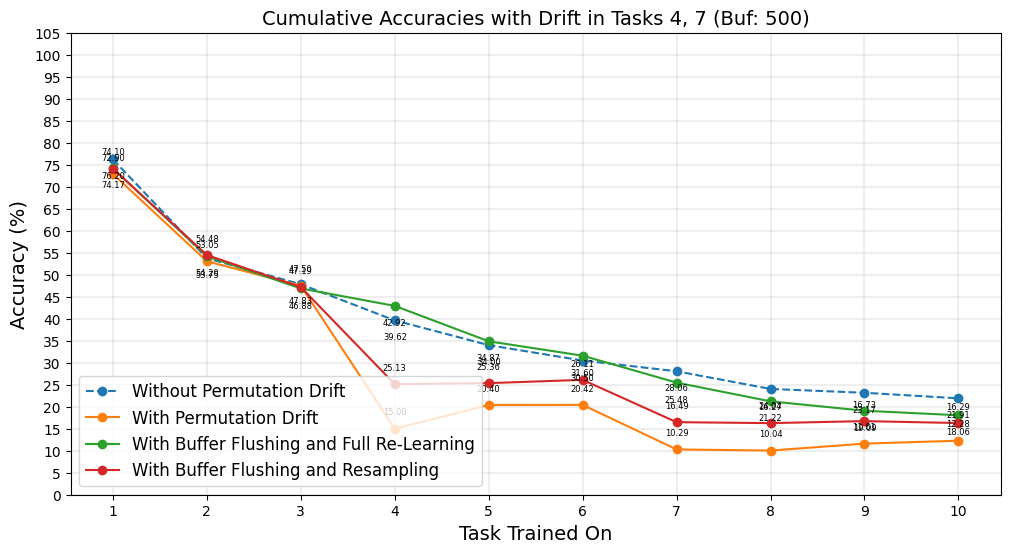

In [42]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [43]:
# er_ace_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-20-25-08-18-05-seq-cifar100-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
# )
# # 31.81, 32.67, 32.85
# # 32.443333333333335 ± 0.45382326466980155
# # plot_results(
# #     er_ace_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

In [44]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-08-18-05-seq-cifar100-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-08-18-05-seq-cifar100-er_ace-buf-5000-drift-6-n-2-adaptation-0.json
FAA: 32.67 ± 0.00
Avg. Forgetting: 31.83 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [45]:
# er_ace_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-21-25-04-44-37-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
# )
# # 16.43, 16.84, 16.85, 16.94, 16.96
# # 16.804000000000002 ± 0.19293522228976281
# # plot_results(
# #     er_ace_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 4, 7",
# # )
# average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

In [46]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-04-44-37-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-04-44-37-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-0.json
FAA: 16.85 ± 0.00
Avg. Forgetting: 48.50 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [47]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-37-04-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 28.77, 29.25, 29.52
# # 29.179999999999996 ± 0.3101612483854165

In [48]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-20-31-07-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 27.13, 27.45, 27.51
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
# )

In [49]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-19-16-36-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-46-24-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-20-31-07-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 27.36 ± 0.17
Avg. Forgetting: 38.41 ± 0.40


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [50]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-18-20-46-seq-cifar100-er_ace-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 27.39, 27.69, 28.15
# # 27.74333333333333 ± 0.3125522178594936

In [51]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-00-34-03-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 27.11, 27.38, 27.38
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
# )

In [52]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-00-34-03-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-23-25-23-37-49-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-23-25-22-41-31-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 27.29 ± 0.13
Avg. Forgetting: 39.81 ± 0.67


### Cumulative Plots

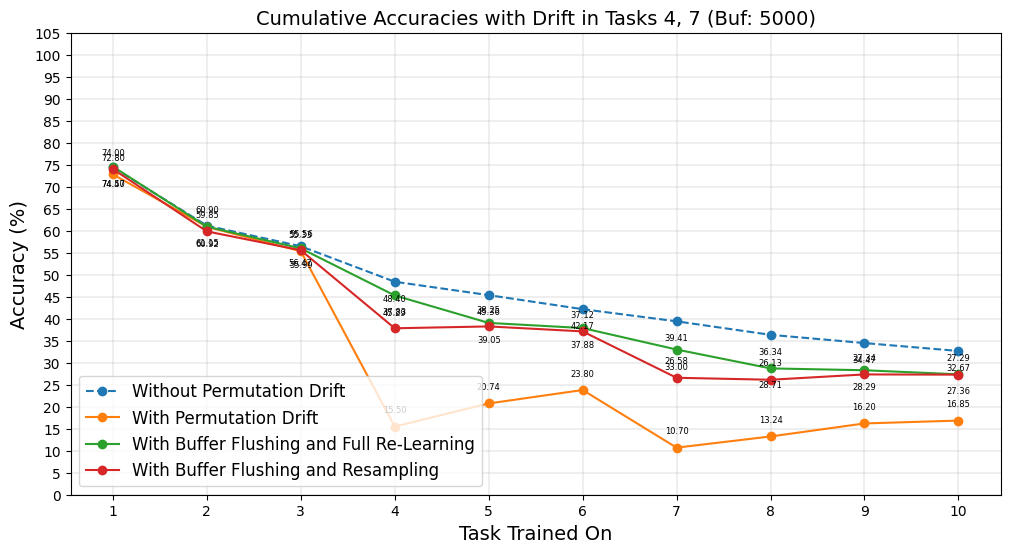

In [53]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [54]:
# derpp_500_accuracy_array_without_drift = read_results(
#     "./logs/01-20-25-22-06-38-seq-cifar100-derpp-buf-500-drift-6-n-1-adaptation-0.json"
# )
# # 12.03, 12.11, 12.20
# # 12.113333333333335 ± 0.0694422221866655
# # plot_results(
# #     derpp_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(derpp_500_accuracy_array_without_drift)[1]

In [55]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-20-25-22-06-38-seq-cifar100-derpp-buf-500-drift-6-n-1-adaptation-0.json"
)

1 files found
1: ./logs/01-20-25-22-06-38-seq-cifar100-derpp-buf-500-drift-6-n-1-adaptation-0.json
FAA: 12.11 ± 0.00
Avg. Forgetting: 69.80 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [56]:
# derpp_500_accuracy_array_with_drift = read_results(
#     "./logs/01-21-25-05-01-17-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 10.27, 10.36, 10.52
# # 10.383333333333333 ± 0.10338708279513883
# # plot_results(
# #     derpp_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 4, 7",
# # )
# average_forgetting(derpp_500_accuracy_array_with_drift)[1]

In [57]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-05-01-17-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-05-01-17-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-0.json
FAA: 10.36 ± 0.00
Avg. Forgetting: 72.03 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [58]:
# before reimplementation
#  derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-35-33-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 17.13, 17.49, 17.83
# # 17.48333333333333 ± 0.2858126814696799

In [59]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-19-51-18-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 16.31, 16.51, 17.52
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=500)",
# )

In [60]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-23-33-51-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-42-22-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-19-51-18-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 16.78 ± 0.53
Avg. Forgetting: 63.39 ± 0.41


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [61]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-20-07-54-seq-cifar100-derpp-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 13.18, 13.29, 13.40
# # 13.29 ± 0.08981462390205013

In [62]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-02-18-12-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 13.26, 13.51, 13.93
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=500)",
# )

In [63]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-03-38-50-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-24-25-02-18-12-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-00-55-36-seq-cifar100-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 13.57 ± 0.28
Avg. Forgetting: 67.61 ± 0.32


### Cumulative Plots

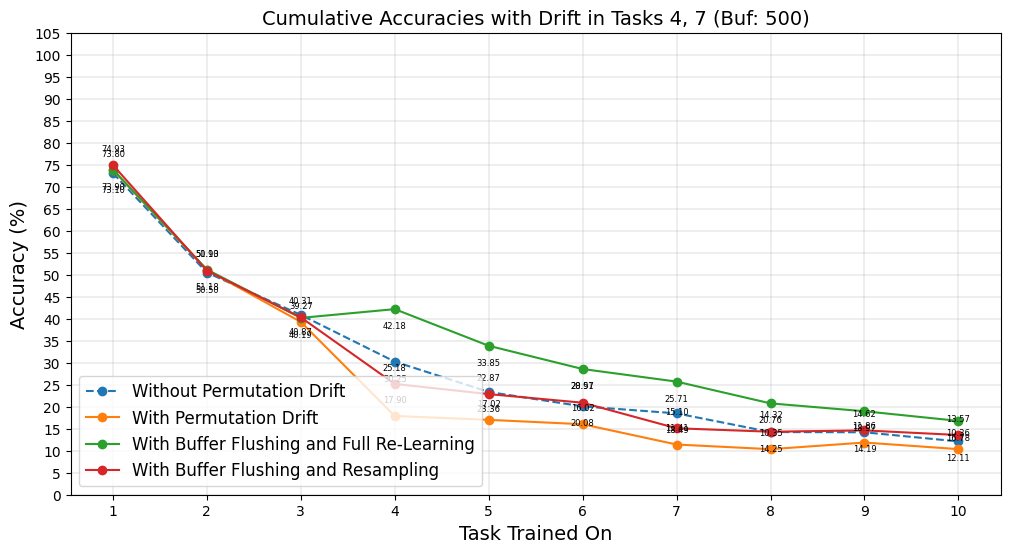

In [64]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [65]:
# derpp_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-21-25-00-05-03-seq-cifar100-derpp-buf-5000-drift-6-n-1-adaptation-0.json"
# )
# # 30.42, 31.04, 31.17
# # 30.876666666666665 ± 0.32724438710066306
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="DER++ Baseline CIL Accuracy",
# )
# average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

In [66]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-00-05-03-seq-cifar100-derpp-buf-5000-drift-6-n-1-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-00-05-03-seq-cifar100-derpp-buf-5000-drift-6-n-1-adaptation-0.json
FAA: 31.04 ± 0.00
Avg. Forgetting: 36.13 ± 0.00


### With Permutation Drift in Tasks 4, 7

In [67]:
# derpp_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-21-25-04-00-20-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
# )
# # 15.39, 15.74, 16.31
# # 15.813333333333333 ± 0.3791510985814956
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="DER++ Accuracy with Drift in Tasks 4, 7",
# )
# average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

In [68]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-04-00-20-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-04-00-20-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-0.json
FAA: 15.74 ± 0.00
Avg. Forgetting: 52.48 ± 0.00


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [69]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-21-25-15-52-35-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 30.83, 30.94, 31.19
# # 30.986666666666665 ± 0.15062831370260107

In [70]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-23-25-23-53-33-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 26.18, 27.74, 28.10
# plot_results(
#     derpp_5000_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 4, 7 and Full Relearning (buf=5000)",
# )

In [71]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-23-25-19-58-09-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-23-25-21-52-31-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-23-25-23-53-33-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 27.34 ± 0.83
Avg. Forgetting: 40.33 ± 1.74


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [72]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-21-25-19-29-35-seq-cifar100-derpp-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 27.67, 27.74, 28.05
# # 27.819999999999997 ± 0.16512621435334454

In [73]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-02-37-07-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 27.50, 27.79, 27.85
# plot_results(
#     derpp_5000_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 4, 7 and Buffer Resampling (buf=5000)",
# )

In [74]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-02-37-07-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-24-25-03-56-36-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-24-25-01-16-22-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 27.71 ± 0.15
Avg. Forgetting: 45.62 ± 0.20


### Cumulative Plots

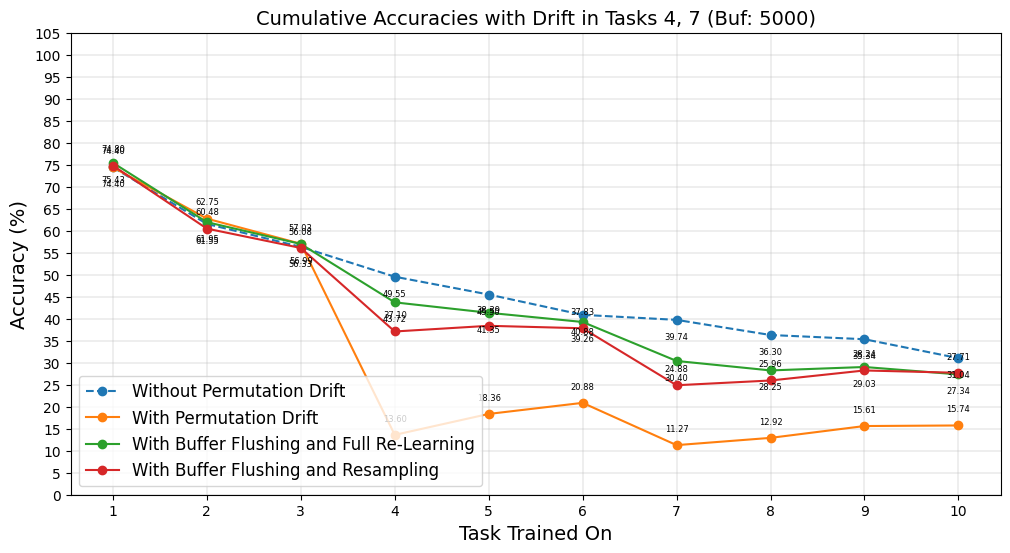

In [75]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# SER

## Buffer 500

### Accuracy Without Drift

In [76]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-01-25-17-49-37-seq-cifar100-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-01-25-15-57-38-seq-cifar100-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-01-25-16-54-22-seq-cifar100-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 26.60 ± 0.28
Avg. Forgetting: 42.38 ± 0.35


### With Permutation Drift in Tasks 4, 7

In [77]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-01-25-18-46-19-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-01-25-19-38-30-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-01-25-20-31-00-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 18.62 ± 0.11
Avg. Forgetting: 51.06 ± 0.12


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [78]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-01-25-22-43-27-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-01-25-23-50-08-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-01-25-21-37-36-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 20.71 ± 0.14
Avg. Forgetting: 41.83 ± 0.35


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [79]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-00-44-05-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-02-25-03-01-39-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json


3: ./reimplementation-logs/04-02-25-01-52-21-seq-cifar100-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 17.73 ± 0.71
Avg. Forgetting: 46.52 ± 0.50


### Cumulative Plots

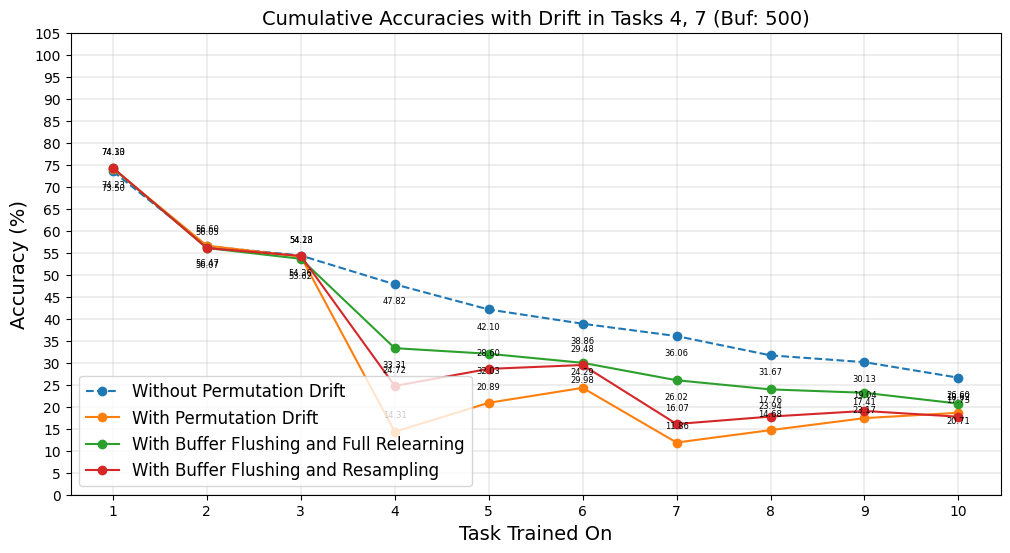

In [80]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [81]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-05-15-33-seq-cifar100-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-02-25-04-10-12-seq-cifar100-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-02-25-06-23-33-seq-cifar100-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 36.18 ± 0.61
Avg. Forgetting: 14.16 ± 0.08


### With Permutation Drift in Tasks 4, 7

In [82]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-07-29-40-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-02-25-09-40-46-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-02-25-08-31-43-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 17.19 ± 0.41
Avg. Forgetting: 34.61 ± 0.20


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [83]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-11-32-08-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-02-25-15-15-39-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-02-25-13-26-05-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 26.79 ± 0.58
Avg. Forgetting: 25.56 ± 0.27


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [84]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-18-48-45-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-02-25-17-36-53-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-02-25-16-26-12-seq-cifar100-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 27.40 ± 0.24
Avg. Forgetting: 34.61 ± 0.06


### Cumulative Plots

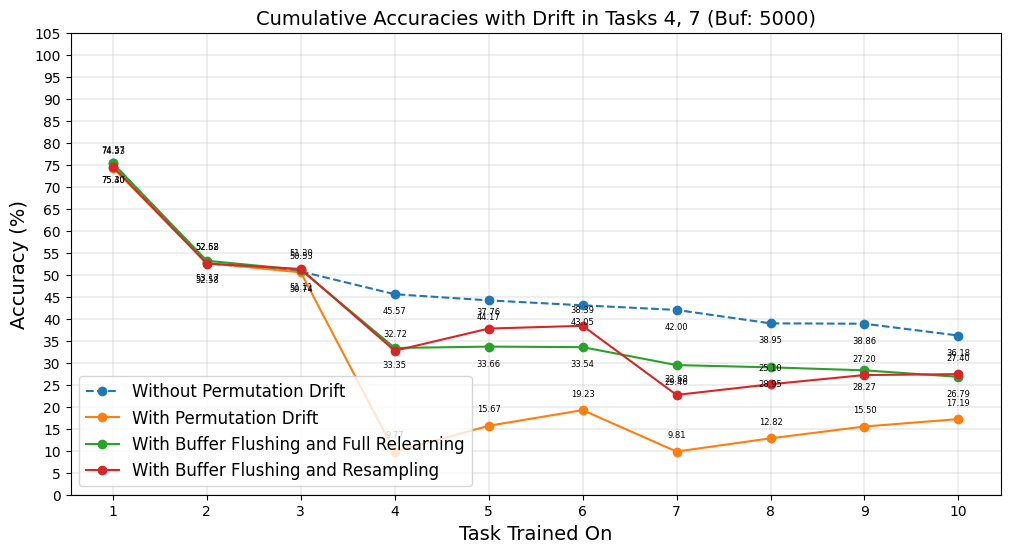

In [85]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [86]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-01-25-20-17-37-seq-cifar100-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-01-25-21-01-44-seq-cifar100-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-01-25-19-33-17-seq-cifar100-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 11.85 ± 0.02
Avg. Forgetting: 73.15 ± 0.36


### With Permutation Drift in Tasks 4, 7

In [87]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-01-25-22-27-41-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-01-25-23-11-22-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-01-25-21-45-25-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 10.45 ± 0.12
Avg. Forgetting: 74.87 ± 0.25


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [88]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-00-14-24-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-02-25-01-24-02-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-02-25-02-35-43-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 18.99 ± 0.14
Avg. Forgetting: 62.31 ± 0.23


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [89]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-04-23-52-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-02-25-03-29-09-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-02-25-05-18-17-seq-cifar100-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 17.11 ± 0.10
Avg. Forgetting: 66.79 ± 0.02


### Cumulative Plots

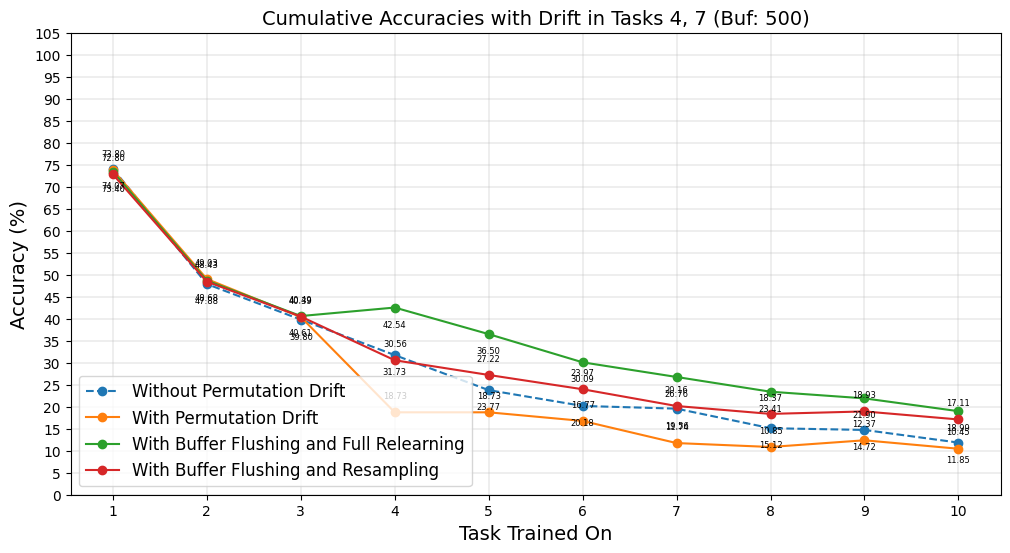

In [90]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [91]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-07-02-36-seq-cifar100-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-02-25-06-10-48-seq-cifar100-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-02-25-07-55-36-seq-cifar100-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 32.78 ± 0.14
Avg. Forgetting: 43.26 ± 0.34


### With Permutation Drift in Tasks 4, 7

In [92]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-09-39-25-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/04-02-25-08-45-25-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/04-02-25-10-32-20-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 19.43 ± 0.12
Avg. Forgetting: 57.74 ± 0.18


### With Permutation Drift in Tasks 4, 7 with Full Relearning

In [93]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-14-33-20-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/04-02-25-11-55-04-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/04-02-25-13-12-34-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 32.06 ± 0.08
Avg. Forgetting: 42.17 ± 0.42


### With Permutation Drift in Tasks 4, 7 with Buffer Resampling

In [94]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-15-26-46-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/04-02-25-16-18-48-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/04-02-25-17-13-00-seq-cifar100-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 31.47 ± 0.31
Avg. Forgetting: 44.51 ± 1.42


### Cumulative Plots

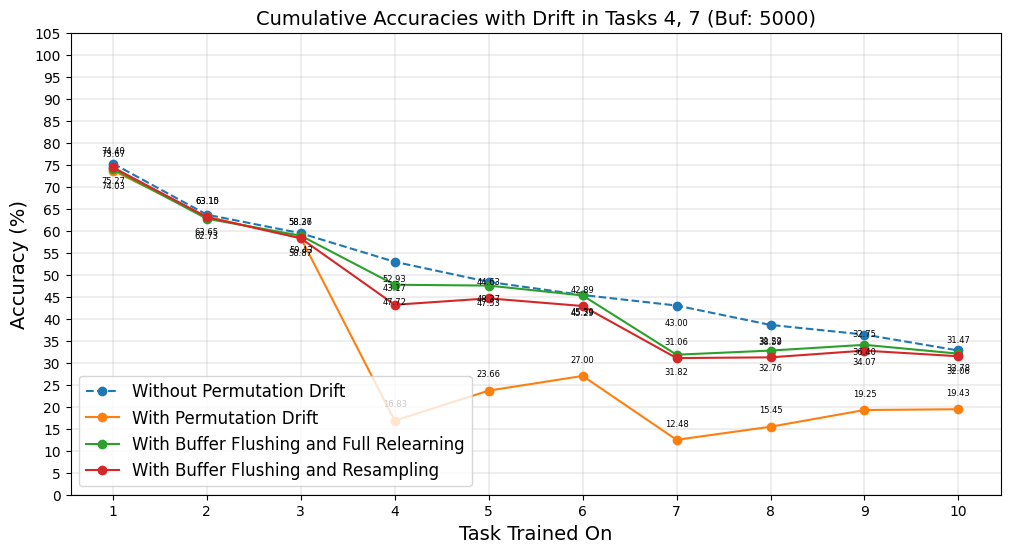

In [95]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 4, 7 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

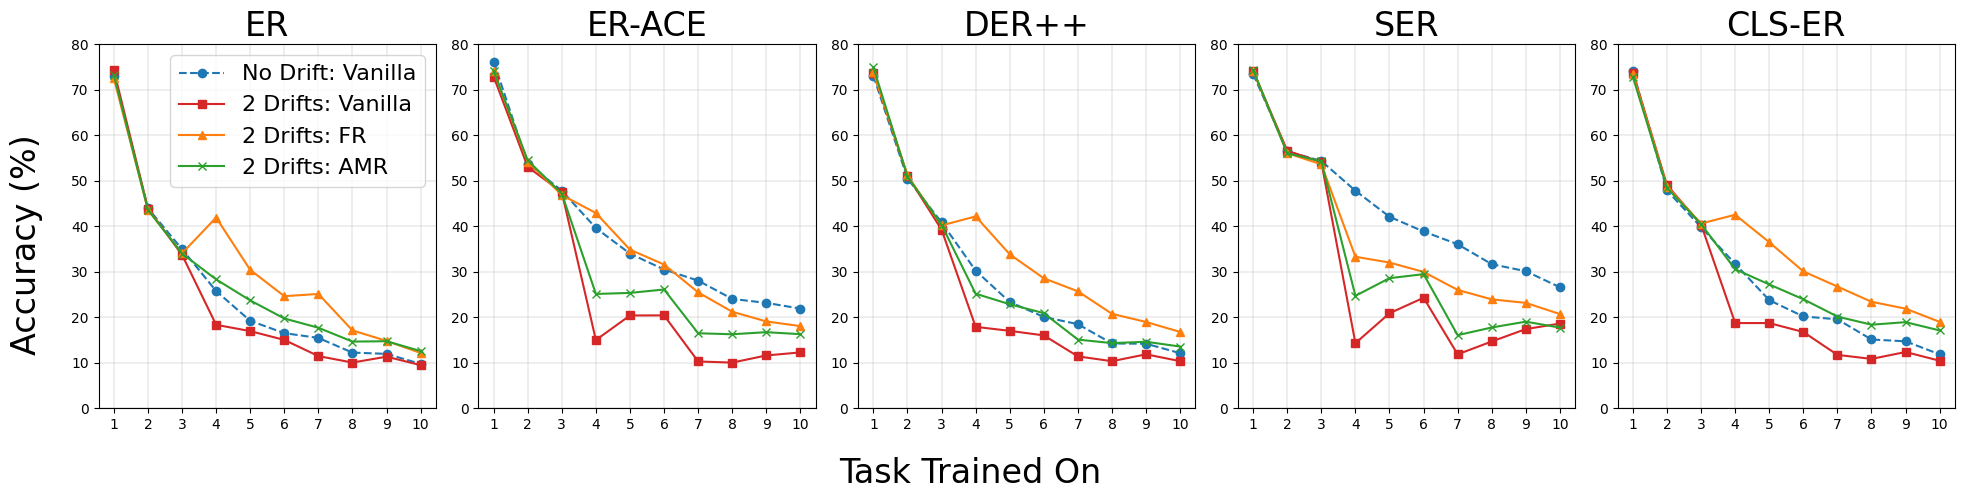

In [99]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    plot_filename="CIFAR100_Buff_500_n_2.pdf",
)

## Buffer 5000

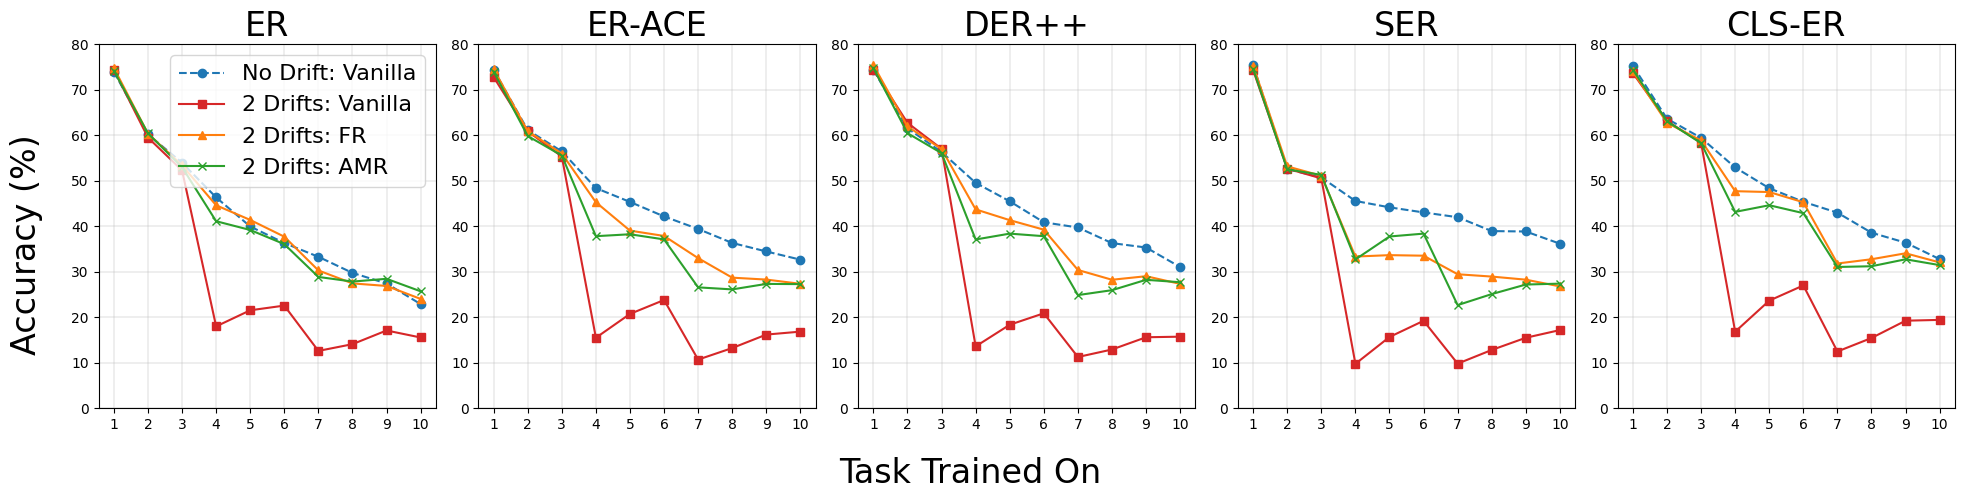

In [100]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    plot_filename="CIFAR100_Buff_5000_n_2.pdf",
)